# QML 104 - More is different ? Working with multiple qubits

In the [previous tutorial](qml103) we saw how we might be able to handle more complex inputs through reuploading. However, we only discussed algorithms with single qubits until now and there is little chance that such algorithms have an impact beyond their pedagogical power.

In this tutorial, we will present one for to introduce multiple qubits and entangle them. We will learn:

- How multiple qubits can work with multiple labels.
- Entanglement might be used to control the performance of the circuit. 

We will always focus on simplicity throughout this tutorial and leave the more complex discussions to the extensive literature.

In [ ]:
# only necessary on colab to have all the required packages installed

!pip install qiskit
!pip install pylatexenc

In [ ]:
from typing import Union, List

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# for splitting the data set
from sklearn.model_selection import train_test_split

# for the quantum circuits
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer

## A multi-label data set

In the [first tutorials](qml101) we saw how to label data that depend only on one input and had binary labels $y_i \in \{0, 1\}$. In the [third tutorial](qml103), we worked with a data set that had a two-dimensional input $\mathbf{x}_i = (x_{1,i}, x_{2,i})$ and a binary label $y_i \in \{0, 1\}$. We will now build up on this work and use a data set that has:

- one dimensional input $x$.
- Labels that go from $y_i \in \{0, 1, 2, 3\}$. Extending our previous data set.

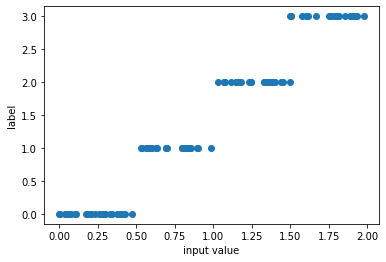

In [ ]:
np.random.seed(1)
xdata = np.random.uniform(0, 2, 100)
ydata = np.ceil(2*xdata)-1

f, ax = plt.subplots()
ax.plot(xdata, ydata, "o")
ax.set_xlabel("input value")
ax.set_ylabel("label");

Once again we split the data set and get into the training.

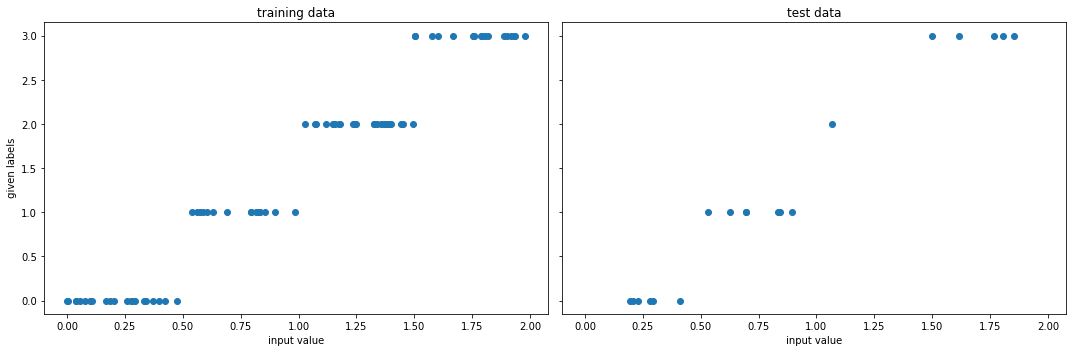

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    xdata, ydata, test_size=0.20, random_state=42
)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax1.plot(x_train, y_train, "o")
ax1.set_xlabel("input value")
ax1.set_ylabel(" given labels")
ax1.set_title("training data")

ax2.plot(x_test, y_test, "o")
ax2.set_xlabel("input value")
ax2.set_title("test data")

f.tight_layout()

## Handling multiple labels

To achieve training now, we have to handle labels that go beyond binary. Quite interestingly there is a multitude of approaches on how to encode such labels, one of them was propose in the original paper [data-reuploading approach](https://quantum-journal.org/papers/q-2020-02-06-226/). However, we will follow a more intuitive path in which we simply use the qubits as [binary encoding](https://en.wikipedia.org/wiki/Binary_number) of the labels. To represent the number $3$, we therefore need two qubits as the result $|11\rangle$ is then translated in $2^1+1^1 = 3$.   In summary, we will 

1. Prepare the initial state, where multiple qubits are initialized in $0$.
2. Apply a parametrized circuit with parameters $\mathbf{w}$ that depend on the input $U(\mathbf{w},x_i)$.
3. Read out the label from the measurement of the qubit.

The main difference is now that we have multiple qubits that we should handle in this approach and we have to choose how to properly parametrize the circuit. This falls into the large class of variational circuits, about which we might do a series of tutorials, if interest exists. A nice review on different choices can be found [in this paper](https://arxiv.org/abs/2008.08605).  Here, we will choose the following parametrization. 

1. We apply a rotation gate $R_x$ on each qubit.
2. We entangle the two qubit through a parametrized two qubit gate. A wide choice exists, but the  $R_{zz}$ gate is especially nice as it creates entanglement and does not commute with the $R_x$ gates.
3. We apply another rotation gate $R_x$ on each qubit.

Let us just visualize it once in `qiskit`.

In [ ]:
sim = Aer.get_backend("aer_simulator")

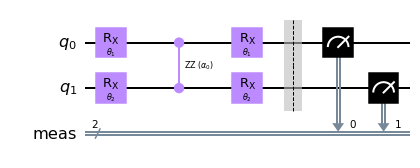

In [ ]:
theta1 = Parameter(r"$\theta_1$")
theta2 = Parameter(r"$\theta_2$")

alpha0 = Parameter(r"$\alpha_0$")

qc = QuantumCircuit(2)

# first upload
qc.rx(theta1, 0)
qc.rx(theta2, 1)

# first processing
qc.rzz(alpha0, 0,1)

# second upload
qc.rx(theta1, 0)
qc.rx(theta2, 1)


qc.measure_all()
qc.draw("mpl")

We can now look at the performance of the code with some randomly initialized weight in predicting the appropiate label.

In [ ]:
def get_accuracy(
    qc: QuantumCircuit, weights: List[float] , alphas: List[float], xvals: List[float], yvals: List[int]) -> Union[float, List[int]]:
    """
    Calculates the accuracy of the circuit for a given set of data.

    Args:
      qc: the quantum circuit
      alphas: the training parameters for the z processing gate
      gammas: the training parameters for the x processing gate
      weights: the weights for the inputs
      xvals: the input values
      yvals: the labels
    Returns:
      The accuracy and the predicted labels.
    """
    pred_labels = np.zeros(len(xvals))
    accurate_prediction = 0
    for ii, xinput, yinput in zip(range(len(xvals)), xvals, yvals.astype(int)):
        # set the circuit parameter
        circuit = qc.assign_parameters(
            {theta1: weights[0]*xinput,
             theta2: weights[1]*xinput,
             alpha0: alphas
             },
            inplace=False,
        )
        # run the job and obtain the counts
        Nshots = 4000
        job = sim.run(circuit, shots=Nshots)
        counts1 = job.result().get_counts()  # e.g. counts = {"00": 2000, "11": 2000}

        # obtain the predicted label on average
        av_label = 0
        for el in counts1:
          av_label += int(el,2)*counts1[el]/Nshots
        pred_label = round(av_label) 
        
        pred_labels[ii] = pred_label
        if yinput == pred_label:
            accurate_prediction += 1
    return accurate_prediction / len(yvals), pred_labels

The randomly initialized circuit has an accuracy of 0.275


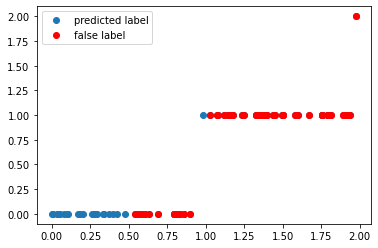

In [ ]:
np.random.seed(123)

weights = np.random.uniform(size=2)
alphas = np.random.uniform()


accuracy, y_pred = get_accuracy(qc, alphas=alphas, weights=weights, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

print(f"The randomly initialized circuit has an accuracy of {accuracy}")

f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

## Training

We once again have to train the circuit as discussed in the[ previous tutorial](qml103) with [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) package to optimize the target function.

In [ ]:
from scipy.optimize import minimize

In [ ]:
def get_cost_for_circ(xvals, yvals, machine=sim):
    """
    Runs parametrized circuit

    Args:
        x: position of the dot
        y: its state label
        params: parameters of the circuit
    """

    def execute_circ(params_flat):
        weights = params_flat[:2]
        alphas = params_flat[2]
        accuracy, y_pred = get_accuracy(qc, alphas=alphas, weights=weights, xvals=xvals, yvals=yvals)
        print(f"accuracy = {accuracy}")
        return 1-accuracy

    return execute_circ

In [ ]:
total_cost = get_cost_for_circ(x_train, y_train, sim)

# initial parameters which are randomly initialized
np.random.seed(123)
params = np.random.uniform(size=3)
params_flat = params.flatten()

# params, which are guessed close to what we know to be a good result
params_flat = [0.9,0.9,0.7]

# minimze with COBYLA optimize, which often performs quite well
res = minimize(total_cost, params_flat, method="COBYLA")

accuracy = 0.975
accuracy = 0.6125
accuracy = 0.3125
accuracy = 0.375
accuracy = 0.2625
accuracy = 0.5375
accuracy = 0.8
accuracy = 0.8
accuracy = 0.75
accuracy = 0.9375
accuracy = 0.95
accuracy = 0.95
accuracy = 0.9625
accuracy = 0.975
accuracy = 0.975
accuracy = 0.9875
accuracy = 0.9625
accuracy = 0.95
accuracy = 0.975
accuracy = 0.9625
accuracy = 0.975
accuracy = 0.975
accuracy = 0.9875
accuracy = 0.9875
accuracy = 0.9625
accuracy = 0.95
accuracy = 0.9625
accuracy = 0.975
accuracy = 0.9625
accuracy = 0.975
accuracy = 0.975
accuracy = 0.975
accuracy = 0.975
accuracy = 0.975
accuracy = 0.975
accuracy = 0.9625
accuracy = 0.975


We can see that the accuracy is converging to a value of more than 95% and it is now time to look into the optimal training parameters.

In [ ]:
opt_weights = res.x[:2]
opt_alphas = res.x[2]

print(f"optimal weights = {opt_weights}")
print(f"optimal alpha = {opt_alphas}")

optimal weights = [0.9010178  0.90824815]
optimal alpha = 0.7131673355135238


We can now test the accuracy on the optimal value of the weights again to test the accuracy.

The trained circuit has an accuracy of 0.96


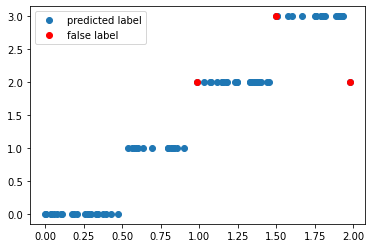

In [ ]:
accuracy, y_pred = get_accuracy(qc, weights=opt_weights, alphas = opt_alphas, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

print(f"The trained circuit has an accuracy of {accuracy:.2}")

f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

We can see quite excellent training for this data set. One common question that always comes up for these kinds of circuits is also about the potential role of entanglement. The simplest thing would be to simply set the alpha parameter to zero.

In [ ]:
accuracy_wo_entanglement, _ = get_accuracy(qc, weights=opt_weights, alphas = 0, xvals=x_train, yvals=y_train)
print(f"The trained circuit without entanglement has an accuracy of {accuracy_wo_entanglement:.2}")

The trained circuit without entanglement has an accuracy of 0.79


We can see that the correlation between the two qubits plays and substantial role in the prediction of the labels. The training of the circuit without any kind of entanglement is left to the reader. Or you just send us a comment if you would like to have a cleaner introduction on this issue.

## Test

Having finished the training, we can test the circuit now on data points that it has never seen.

The circuit has a test accuracy of 1.0


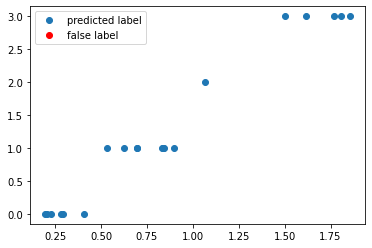

In [ ]:
test_accuracy, y_test_pred = get_accuracy(
    qc, weights=opt_weights,  alphas = opt_alphas, xvals=x_test, yvals=y_test
)

false_label = abs(y_test_pred - y_test) > 0

x_false = x_test[false_label]
y_false = y_test_pred[false_label]

print(f"The circuit has a test accuracy of {test_accuracy:.2}")

f, ax = plt.subplots()
ax.plot(x_test, y_test_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

## Summary and outlook

In this last tutorial of this introductory series, we have seen that the data reuploading can be extended towards multiple labels. 
- The crucial step was the extension to multiple qubits. 
- To make the algorithm work efficiently we entangled the qudits with an entanglement gate and then trained the full circuit with the whole data set.

Of course, we have not gone into complex data-sets like the MNIST or other problems in this series. This will be up to the more complex literature or more advanced courses. However, we hope that this series gave you a basic idea of some fairly common concepts that are used in the field nowadays.